In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import scripts.read_data_from_db as rd
import scripts.data_cleaning as dc
import scripts.utils as util

In [2]:
df = rd.read_data(table_name='processed_data')

INFO:scripts.read_data_from_db:Data fetched succesfully


In [3]:
pysqldf = lambda q: sqldf(q, globals())

## User Engagement Analysis

### Session Frequency per user

In [5]:
query = ''' 
        SELECT
            "MSISDN/Number" AS MSISDN,
            COUNT(DISTINCT "Bearer Id") AS SessionFrequency
        FROM df
        GROUP BY "MSISDN/Number"
        ORDER BY SessionFrequency DESC
        LIMIT 10
'''

result_df = pysqldf(query)
result_df

,MSISDN,SessionFrequency
0,3.362632e+10,520
1,3.362578e+10,17
2,3.361489e+10,17
3,3.365973e+10,16
4,3.376054e+10,15
5,3.367588e+10,15
6,3.366716e+10,13
7,3.376041e+10,12
8,3.362708e+10,12
9,3.360452e+10,12


### Session duration per user

In [6]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration
    FROM df
    GROUP BY "MSISDN/Number" 
    ORDER BY SessionDuration DESC
    LIMIT 10;
    ''' 

result_df = pysqldf(query)
result_df


,MSISDN/Number,SessionDuration
0,3.362632e+10,81238323.0
1,3.362578e+10,18553754.0
2,3.361489e+10,9966898.0
3,3.376054e+10,9279434.0
4,3.366716e+10,8744914.0
5,3.366284e+10,6614270.0
6,3.366469e+10,6288730.0
7,3.360313e+10,6287761.0
8,3.366746e+10,5649882.0
9,3.376041e+10,5321667.0


### Total traffic per user

In [7]:
query = ''' 
    SELECT 
        "MSISDN/Number",
        SUM("Total DL (Bytes)") AS TotalDownload,
        SUM("Total UL (Bytes)") AS TotalUpload,
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ORDER BY TotalTraffic DESC
    LIMIT 10;
'''

pysqldf(query)

,MSISDN/Number,TotalDownload,TotalUpload,TotalTraffic
0,3.362632e+10,4.942252e+11,4.499495e+10,5.392201e+11
1,3.361489e+10,8.156743e+09,6.894830e+08,8.846226e+09
2,3.376054e+10,7.811295e+09,7.034786e+08,8.514774e+09
3,3.362578e+10,7.770043e+09,7.295774e+08,8.499621e+09
4,3.367588e+10,7.309542e+09,5.815688e+08,7.891111e+09
5,3.365973e+10,7.081602e+09,6.242603e+08,7.705863e+09
6,3.366646e+10,6.903440e+09,4.050610e+08,7.308501e+09
7,3.376041e+10,6.610852e+09,5.215189e+08,7.132371e+09
8,3.366471e+10,6.400774e+09,4.712445e+08,6.872018e+09
9,3.369879e+10,6.010556e+09,5.303431e+08,6.540899e+09


### Aggregating engagement metrics

In [4]:
query = '''
    SELECT 
        "MSISDN/Number",
        SUM("Dur. (ms)") AS SessionDuration,
        COUNT(DISTINCT "Bearer Id") AS SessionFrequency,
        (SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)")) AS TotalTraffic
    FROM df
    GROUP BY "MSISDN/Number"
    ''' 

aggregated_df = pysqldf(query)
aggregated_df.tail()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
106851,3.379000e+10,8810.0,1,714641641.0
106852,3.379000e+10,140988.0,1,480307335.0
106853,3.197021e+12,877385.0,1,232123971.0
106854,3.370000e+14,253030.0,1,596287824.0
106855,8.823971e+14,869844.0,1,139153646.0


### Normalize engagement metrics

In [5]:
scaler = MinMaxScaler()
columns_to_normalize = ["SessionDuration", "SessionFrequency","TotalTraffic"]
customer_id = aggregated_df['MSISDN/Number']
transformed_data = scaler.fit_transform(aggregated_df[columns_to_normalize])
normalized_data = pd.DataFrame(transformed_data, columns=columns_to_normalize)
df_normalized = pd.concat([customer_id, normalized_data], axis=1)
df_normalized

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
0,3.360100e+10,0.001349,0.000000,0.001568
1,3.360100e+10,0.002143,0.000000,0.000229
2,3.360100e+10,0.001574,0.000000,0.001044
3,3.360101e+10,0.000526,0.000000,0.000722
4,3.360101e+10,0.000369,0.001927,0.002641
...,...,...,...,...
106851,3.379000e+10,0.000021,0.000000,0.001264
106852,3.379000e+10,0.001648,0.000000,0.000829
106853,3.197021e+12,0.010713,0.000000,0.000369
106854,3.370000e+14,0.003027,0.000000,0.001044


### K-means clustering with k = 3

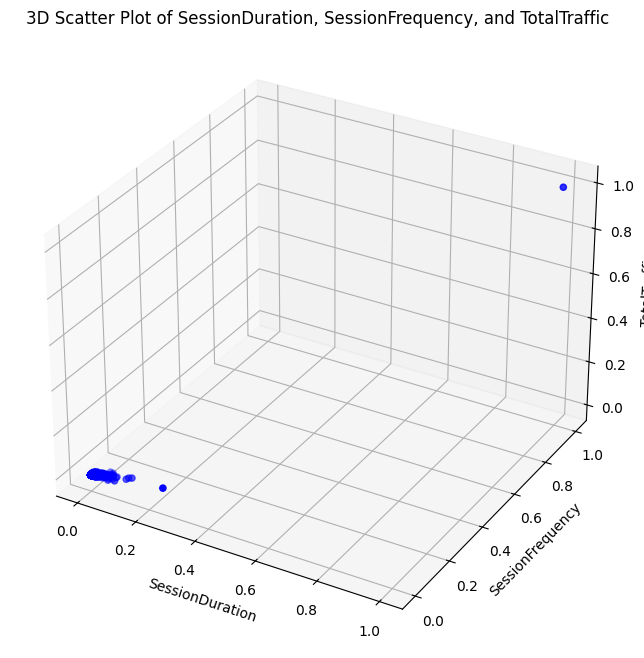

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_normalized['SessionDuration'], df_normalized['SessionFrequency'], df_normalized['TotalTraffic'], c='blue', marker='o')

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title('3D Scatter Plot of SessionDuration, SessionFrequency, and TotalTraffic')
plt.show()

### handle Outliers

In [7]:
processed_df = dc.handle_outliers(normalized_data, columns_to_normalize)

### plot after handling outliers

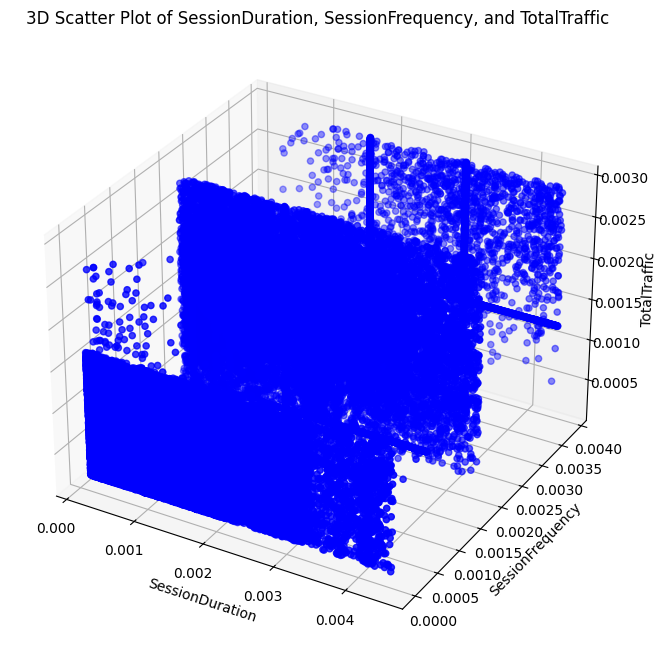

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(processed_df['SessionDuration'], processed_df['SessionFrequency'], processed_df['TotalTraffic'], c='blue', marker='o')

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title('3D Scatter Plot of SessionDuration, SessionFrequency, and TotalTraffic')
plt.show()

In [10]:
selected_columns = columns_to_normalize
X = processed_df[selected_columns]
k = 3

kmeans = KMeans(n_clusters=3, random_state=0, n_init=25) 
kmeans.fit(X)

processed_df['Cluster'] = kmeans.labels_

### Plot of clustered engagement

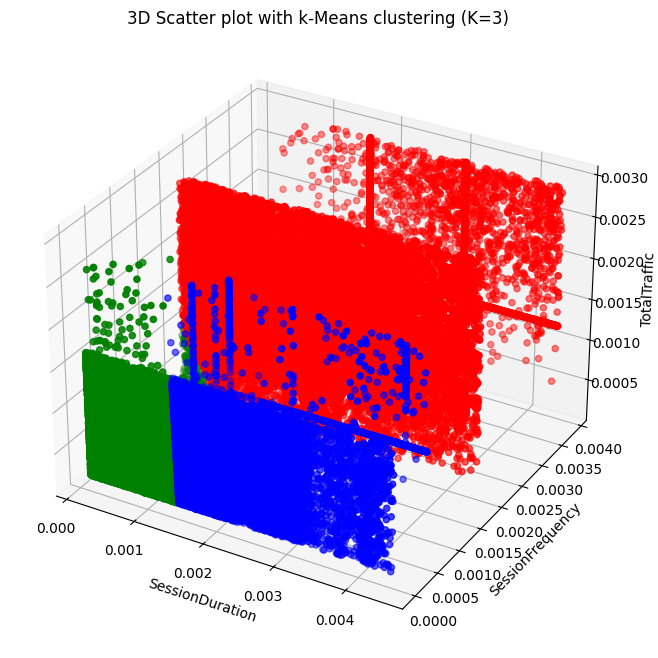

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cluster_colors = {0: 'red', 1: 'blue', 2:'green'}

for cluster_label, color in cluster_colors.items():
    cluster_data = processed_df[processed_df['Cluster'] == cluster_label]
    ax.scatter(
        cluster_data['SessionDuration'], 
        cluster_data['SessionFrequency'], 
        cluster_data['TotalTraffic'], 
        label=f'Cluster {cluster_label}',
        color=color
        )

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title(f'3D Scatter plot with k-Means clustering (K={k})')
plt.show()

### Minimum, Maximum, average and total in each cluster

In [12]:
grouped_df = (processed_df
                .groupby('Cluster')[["SessionDuration", "SessionFrequency", "TotalTraffic"]]
                .agg(['min', 'max', 'mean', 'sum']))

grouped_df

SessionDuration                                SessionFrequency  \
                    min       max      mean        sum              min   
Cluster                                                                   
0              0.000177  0.004464  0.002089  53.776775         0.000741   
1              0.001381  0.004464  0.002044  66.537004         0.000000   
2              0.000162  0.001454  0.000809  39.268448         0.000000   

                                       TotalTraffic                      \
              max      mean        sum          min       max      mean   
Cluster                                                                   
0        0.003854  0.002240  57.656305     0.000201  0.002906  0.001730   
1        0.000741  0.000063   2.044788     0.000182  0.002897  0.000981   
2        0.001927  0.000005   0.246184     0.000182  0.002901  0.000934   

                    
               sum  
Cluster             
0        44.523347  
1        31.924176  
2        45.361959

### Grouping users in k engagement clusters using elbow method


/home/misge/miniconda3/envs/tenx/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/misge/miniconda3/envs/tenx/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


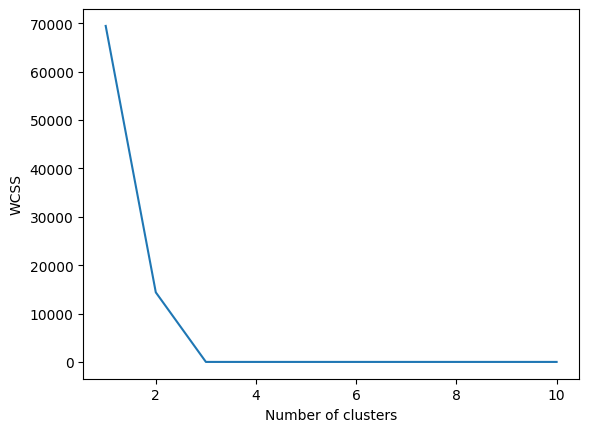

In [14]:
wcss = []
X = processed_df.iloc[:, [1, 3]]

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##### The ideal value for K in the engagement analysis remains consistent at K = 3, the same as the previously used value.